# Logistic regression Assumptions

- log-odds linearity
- multicollinearity
- outliers


## Data Loading


In [54]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import json

from python_proj.utils.util import safe_save_fig, subtract_dict, Counter
import python_proj.utils.exp_utils as exp_utils

file_name = "dataset_90_days_started_11_07_23_preprocessed"
base_path = exp_utils.BASE_PATH
data_path = f'{base_path}/final_data/{file_name}.csv'
figure_base_path = f"{base_path}/figures/modelling/{file_name}/"

# Meta stuff.
pr_merged_key = 'PullRequestIsMerged'
ftc_key = 'SubmitterIsFirstTimeContributor'
seed_counter = Counter()


# Loads regular dataframe.
df: pd.DataFrame = pd.read_csv(filepath_or_buffer=data_path, header=0)
if 'Unnamed: 1' in df.columns:
    df = df.drop(['Unnamed: 1', "Project Name.1"], axis=1)
print(df.columns)

# Loads first-time contributor data frame.
print(f'{len(df)=}')

# Creates sub-datasets.
metadata_fields = ['ID', 'Project Name',
                   'Submitter ID', 'PR Number', 'Closed At']
dependent_fields = [pr_merged_key]
independent_fields = [field for field in df.columns
                      if (field not in metadata_fields
                          and field not in dependent_fields)]

df[independent_fields].describe()


Index(['Project Name', 'ID', 'Submitter ID', 'PR Number', 'Closed At',
       'PullRequestIsMerged', 'ControlIntegratedBySameUser',
       'ControlPullRequestHasComments', 'ControlHasHashTagInDescription',
       'IntraProjectSubmitterPullRequestSuccessRate',
       'EcosystemExperienceSubmitterPullRequestSuccessRate',
       'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate',
       'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate',
       'SubmitterIsFirstTimeContributor',
       'ControlPullRequestHasCommentByExternalUser',
       'ln(1 + ControlPullRequestLifeTimeInMinutes)',
       'ln(1 + ControlNumberOfCommitsInPullRequest)',
       'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)',
       'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)',
       'ln(1 + IntraProjectSubmitterPullRequestCommentCount)',
       'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)',
       'ln(1 + EcosystemExperienceSubmitterPullReques

,IntraProjectSubmitterPullRequestSuccessRate,EcosystemExperienceSubmitterPullRequestSuccessRate,DependencyEcosystemExperienceSubmitterPullRequestSuccessRate,InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,ln(1 + ControlPullRequestLifeTimeInMinutes),ln(1 + ControlNumberOfCommitsInPullRequest),ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator),ln(1 + IntraProjectSubmitterPullRequestSubmissionCount),ln(1 + IntraProjectSubmitterPullRequestCommentCount),ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount),...,ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + EcosystemExperienceSubmitterIssueCommentCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + WeightedFirstOrderInDegreeCentrality),ln(1 + WeightedFirstOrderOutDegreeCentrality),ln(1 + IntegratorToSubmitterLinkIntensity),ln(1 + SubmitterToIntegratorLinkIntensity)
count,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,...,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06
mean,5.031060e-01,4.033846e-01,9.886411e-02,5.955554e-02,4.194170e-01,1.184075e-01,2.985244e-01,1.690983e-01,1.435135e-01,1.609840e-01,...,8.727044e-02,1.451445e-01,1.149472e-02,1.974474e-02,9.567961e-03,1.759318e-02,8.880630e-02,7.436784e-02,3.906829e-02,5.341273e-02
std,4.710933e-01,4.524701e-01,2.911591e-01,2.291029e-01,2.256877e-01,7.149888e-02,1.868845e-01,1.844529e-01,1.872975e-01,2.112526e-01,...,1.245585e-01,1.815501e-01,5.409527e-02,8.016440e-02,5.262551e-02,8.250659e-02,1.050377e-01,9.865330e-02,9.881875e-02,1.125092e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.364007e-01,7.525668e-02,1.658001e-01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.842105e-01,0.000000e+00,0.000000e+00,0.000000e+00,4.432366e-01,7.525668e-02,2.971935e-01,9.319256e-02,0.000000e+00,1.001133e-01,...,0.000000e+00,7.753347e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.426082e-02,3.552807e-02,0.000000e+00,0.000000e+00
75%,1.000000e+00,9.393939e-01,0.000000e+00,0.000000e+00,5.860667e-01,1.505134e-01,4.381600e-01,3.095790e-01,2.761367e-01,2.810535e-01,...,1.416667e-01,2.575606e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.366047e-01,1.118788e-01,0.000000e+00,4.668350e-02
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [55]:
# FTC selection

df = df[df[ftc_key] == True]
not_applicable_fields = [
    ftc_key,
    'IntraProjectSubmitterPullRequestSuccessRate',
    'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)'
]
df = df.drop(not_applicable_fields, axis=1)
independent_fields = [
    field for field in independent_fields if field not in not_applicable_fields]
print(len(df))


428430


In [56]:
# Drops all ecosystem fields.

from python_proj.utils.util import get_matching
dropped_fields = list(get_matching(independent_fields, r'.*(?=Ecosystem).*'))
print(f'{len(dropped_fields)=}')
print(f'{dropped_fields=}')

df = df.drop(dropped_fields, axis=1)
independent_fields = [field for field in independent_fields if field not in dropped_fields]

df.describe()

len(dropped_fields)=15
dropped_fields=['EcosystemExperienceSubmitterPullRequestSuccessRate', 'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterIssueCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount

,ID,Submitter ID,PR Number,ln(1 + ControlPullRequestLifeTimeInMinutes),ln(1 + ControlNumberOfCommitsInPullRequest),ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator),ln(1 + IntraProjectSubmitterPullRequestCommentCount),ln(1 + IntraProjectSubmitterIssueSubmissionCount),ln(1 + IntraProjectSubmitterIssueCommentCount),ln(1 + WeightedFirstOrderInDegreeCentrality),ln(1 + WeightedFirstOrderOutDegreeCentrality),ln(1 + IntegratorToSubmitterLinkIntensity),ln(1 + SubmitterToIntegratorLinkIntensity)
count,4.284300e+05,4.284300e+05,428430.000000,428430.000000,428430.000000,428430.000000,428430.000000,428430.000000,428430.000000,428430.000000,428430.000000,428430.000000,428430.000000
mean,1.214980e+08,5.138784e+06,584.353323,0.491606,0.106393,0.198827,0.006010,0.011772,0.016827,0.041597,0.031895,0.011337,0.015206
std,9.547977e+07,8.027468e+06,1732.653471,0.223157,0.060791,0.165123,0.033866,0.038788,0.055467,0.075938,0.067606,0.048256,0.055096
min,1.153000e+03,1.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.807955e+07,4.987750e+05,30.000000,0.334558,0.075257,0.082900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.013051e+08,1.680573e+06,122.000000,0.503277,0.075257,0.165800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.891515e+08,6.322656e+06,470.000000,0.662247,0.119279,0.306767,0.000000,0.000000,0.000000,0.053422,0.031923,0.000000,0.000000
max,3.617756e+08,5.973444e+07,82976.000000,1.000000,1.000000,0.996223,0.735845,0.829546,0.907261,0.905874,0.880496,0.740970,0.756560


## Log-odds linearity


### Visual checking


untransformed


ln(1 + ControlPullRequestLifeTimeInMinutes):
0.00    0.001063
0.25    0.334583
0.50    0.503300
0.75    0.662251
1.00    1.000000
Name: ln(1 + ControlPullRequestLifeTimeInMinutes), dtype: float64

x=[0.20336900320220547, 0.4299172709600767, 0.5798843521215297, 0.761122924781113], y=[0.9112443210498485, 1.272759108155697, 0.9142263431405869, -0.2964291750725746]
ln(1 + ControlNumberOfCommitsInPullRequest):
0.00    0.075257
0.25    0.075257
0.50    0.075257
0.75    0.119279
1.00    1.000000
Name: ln(1 + ControlNumberOfCommitsInPullRequest), dtype: float64

x=[0.0752566818678054, 0.0752566818678054, 0.0752566818678054, 0.1505133637356109], y=[0.7017281707009778, 0.7017281707009778, 0.6961897396949585, 0.58786737240966]
ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator):
0.00    0.083214
0.25    0.131892
0.50    0.233612
0.75    0.346998
1.00    1.000000
Name: ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator), dtype: float64

x=[0.08321436185461646, 0.16642872370923292

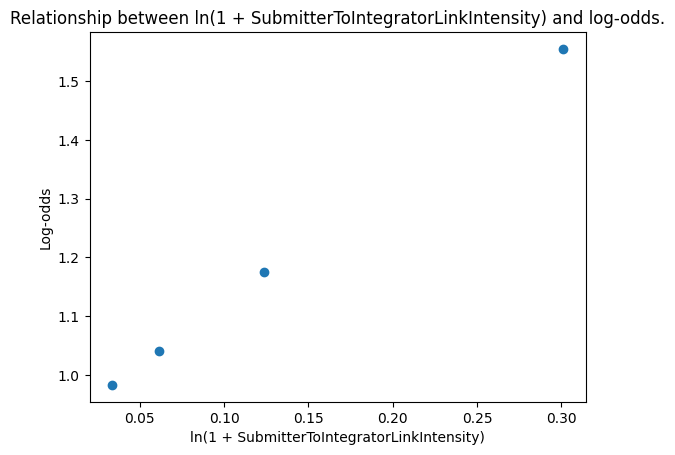

In [57]:
import regex as re
from numbers import Number
from typing import Callable, Iterator
import numpy as np
from python_proj.utils.util import tuple_chain


def test_log_linearity(
    independents: pd.DataFrame,
    dependent: pd.Series,
    transform_title: str = ""
):
    continuous_fields = independents.select_dtypes(include='number')

    all_data = pd.DataFrame()
    all_data[continuous_fields.columns] = continuous_fields.copy()
    all_data[pr_merged_key] = dependent.copy()

    for field in continuous_fields.columns:
        # Creates copy of the relevant fields.
        included = pd.DataFrame()
        included[field] = all_data[field].copy()
        included[pr_merged_key] = all_data[pr_merged_key].copy()

        # Removes data that will signifcantly skew the results.
        if re.match(r'.*SuccessRate.*', field):
            # TODO: Figure out what to do with success rate.
            # We can't properly test the log-linearity with the current data.
            # count_field = field[:-len('SuccessRate')] + "SubmissionCount"
            stripped_field = field[:-len('SuccessRate')]
            count_field = f'ln(1 + {stripped_field}SubmissionCount)'
            included[count_field] = all_data[count_field].copy()
            included = included[included[count_field] > 0]
            perc_quantiles = [0, 0.1, 0.25, 0.4, 0.5, 0.6, 0.75, 0.9, 1]
        else:
            included = included[included[field] > 0]
            perc_quantiles = [0, 0.25, 0.5, 0.75, 1]

        # Calculates quantiles.
        quantiles = included[field].quantile(perc_quantiles)
        print(f'{field}:')
        print(quantiles)
        print()

        x = []
        y = []
        skip_flag = False
        for r_start, r_end in tuple_chain(list(quantiles)):
            quant_data: pd.DataFrame = included[(
                included[field] >= r_start) & (included[field] <= r_end)]
            # quant_mean = quant_data[field].mean()
            quant_mean = quant_data[field].median()
            merged_entries = quant_data[quant_data[pr_merged_key] == True]
            probability = len(merged_entries) / len(quant_data)
            if probability == 1:
                skip_flag = True
                break
            log_odds = np.log(probability / (1 - probability))
            x.append(quant_mean)
            y.append(log_odds)

        if skip_flag:
            print(f'Skipped {field} because of division by zero.')
            continue

        print(f'{x=}, {y=}')

        plt.clf()
        plt.scatter(x, y)
        plt.title(f"Relationship between {field} and log-odds.")
        plt.xlabel(field)
        plt.ylabel("Log-odds")

        output_path = f'{figure_base_path}/log-odds-independence/{transform_title}/{field}'
        safe_save_fig(output_path)


def test_log_linearity_with_transforms(
    transforms: Iterator[Callable[[Number], Number]],
    independents: pd.DataFrame,
    dependent: pd.Series,
    figure_subfolder: str,
):
    continuous_fields = independents.select_dtypes(include='number')
    for transform in transforms:
        print(f"\n{transform.__name__}")
        transformed_independents = continuous_fields.copy()
        for field in transformed_independents.columns:
            transformed_independents[field] = transformed_independents[field]\
                .apply(transform)
            mn = transformed_independents[field].min()
            mx = transformed_independents[field].max()
            transformed_independents[field] = transformed_independents[field]\
                .apply(lambda x: (x - mn) / (mx - mn))
        test_log_linearity(transformed_independents,
                           dependent, f'{figure_subfolder}/{transform.__name__}')


def untransformed(value):
    return value


def ln_transform(value):
    return np.log(1 + value)


def sqrt_transform(value):
    return np.sqrt(1 + value)


def cbrt_transform(value):
    return np.cbrt(1 + value)


def reciprocal_transform(value):
    return 1 / (1 + value)


def squared_transform(value):
    return value ** 2


def ln_ln_transform(value):
    return np.log(1 + np.log(1 + value))


def ln_eps_transform(value):
    return np.log(0.1 + value)


def ln_eps_e2_transform(value):
    return np.log(0.01 + value)


def ln_eps_e3_transform(value):
    return np.log(0.001 + value)


def cubed_transform(value):
    return value ** 3


def ln_complement(value):
    return np.log(1.0 + (1.0 - value))


def ln_eps_complement(value):
    return np.log(0.001 + (1.0 - value))


def ln_eps_e5_complement(value):
    return np.log(0.00001 + (1.0 - value))


def compl_squared_compl(value):
    return 1.0 - ((1.0 - value) ** 2)


transforms = [
    untransformed,
    # ln_transform,
    # sqrt_transform,
    # cbrt_transform,
    # reciprocal_transform,
    # ln_complement,
    # ln_eps_complement,
    # compl_squared_compl,
    # squared_transform,
    # cubed_transform,
    # ln_ln_transform,
    # ln_eps_e2_transform,
    # ln_eps_e3_transform,
    # ln_eps_e5_complement
]


# Full model.
independents = df[independent_fields]
dependent = df[pr_merged_key]
test_log_linearity_with_transforms(
    transforms, independents, dependent, "dependency_model")


## Multicolinearity


In [58]:

# Standardized list of multicollinear fields.
multicollinear_fields = [
    # Confounds
    "ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)",

    # n/a
    "ControlIntegratedBySameUser",

    # intra-proj
    "ln(1 + IntraProjectSubmitterIssueSubmissionCount)",
    "ln(1 + IntraProjectSubmitterPullRequestCommentCount)",
    "ln(1 + IntraProjectSubmitterIssueCommentCount)",

    # multicollinear
    "ln(1 + WeightedFirstOrderOutDegreeCentrality)",
    "ln(1 + SubmitterToIntegratorLinkIntensity)",

    # "ln(1 + WeightedFirstOrderInDegreeCentrality)",
    # "ln(1 + IntegratorToSubmitterLinkIntensity)",
]

print(f'Removing {len(multicollinear_fields)} / {len(independent_fields)} fields to account for multicollinearity.')


Removing 7 / 14 fields to account for multicollinearity.


In [59]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


def change_bin_fields_to_float(__df: pd.DataFrame):
    repl_df = __df.copy()
    value_mapper = {False: 0, True: 1}

    binary_fields = __df.select_dtypes(exclude='number')
    for feature in binary_fields:
        repl_df[feature] = __df[feature].replace(value_mapper)

    return repl_df


tested_predictors = df[independent_fields].drop(multicollinear_fields, axis=1)
tested_predictors = change_bin_fields_to_float(tested_predictors)

vif_df = pd.DataFrame()
vif_df['variable'] = tested_predictors.columns
vif_df['VIF'] = [variance_inflation_factor(tested_predictors.values, i)
                 for i in range(tested_predictors.shape[1])]

print(vif_df)


                                       variable       VIF
0                 ControlPullRequestHasComments  4.104381
1                ControlHasHashTagInDescription  1.408862
2    ControlPullRequestHasCommentByExternalUser  1.564868
3   ln(1 + ControlPullRequestLifeTimeInMinutes)  4.457275
4   ln(1 + ControlNumberOfCommitsInPullRequest)  3.182445
5  ln(1 + WeightedFirstOrderInDegreeCentrality)  1.408082
6    ln(1 + IntegratorToSubmitterLinkIntensity)  1.179502


In [60]:
problematic_vif = vif_df[vif_df['VIF'] >= 5]
print(f"Problematic VIF fields: {len(problematic_vif)}.")
print("Problematic VIF scores:")
print(problematic_vif)


Problematic VIF fields: 0.
Problematic VIF scores:
Empty DataFrame
Columns: [variable, VIF]
Index: []


coof_threshold=0.5
Correlating pairs:
[]

Transitive closure of correlating pairs:
[
    []
]


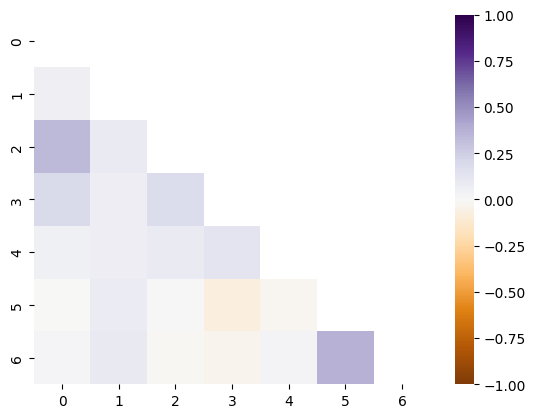

In [61]:
import seaborn as sb
import json
from python_proj.utils.util import SafeDict

tick_labels = list(range(len(vif_df)))
corr = tested_predictors.corr(method='spearman')
rows, cols = corr.shape
mask = np.invert(np.tril(np.ones((rows, cols), dtype=bool), k=-1))
dataplot = sb.heatmap(corr, cmap="PuOr",
                      xticklabels=tick_labels, yticklabels=tick_labels,
                      mask=mask,
                      vmin=-1, vmax=1)


def get_correlating_fields(coof_threshold, corr):
    print(f'{coof_threshold=}')
    correlating_fields = []
    # print(corr)
    for rowIndex, row in corr.iterrows():  # iterate over rows
        for columnIndex, coof in row.items():
            if columnIndex <= rowIndex:
                continue
            if abs(coof) < coof_threshold:
                continue
            correlating_fields.append([columnIndex, rowIndex, coof])
    correlating_fields = [list(entry) for entry in correlating_fields]
    print("Correlating pairs:\n" + json.dumps(correlating_fields, indent=4) + "\n")
    return correlating_fields


correlating_fields = get_correlating_fields(coof_threshold=0.5, corr=corr)

# Identify problematic fields:
presence_counts = SafeDict(default_value=0)
for (field_a, field_b, _) in correlating_fields:
    presence_counts[field_a] += 1
    presence_counts[field_b] += 1
pc = list(presence_counts.items())
pc.sort(key=lambda x: x[1])
# print(f'Variable correlation frequency:\n{json.dumps(pc, indent=4)}\n')

# Generate transitive closures


def unify_if_overlapping(collections: list[list]):
    # gather the lists that do overlap
    overlapping = [x for x in collections if
                   any(x_element in [y for k in collections
                                     if k != x for y in k]
                       for x_element in x)]
    # flatten and get unique
    overlapping = sorted(list(set([z for x in overlapping for z in x])))
    # get the rest
    non_overlapping = [x for x in collections if all(
        y not in overlapping for y in x)]
    # use the line bellow only if merged non-overlapping elements are desired
    # non_overlapping = sorted([y for x in non_overlapping for y in x])
    non_overlapping.append(overlapping)
    return non_overlapping


correlating_no_coof = [(a, b) for (a, b, _) in correlating_fields]
unified = unify_if_overlapping(correlating_no_coof)
print("Transitive closure of correlating pairs:\n" +
      json.dumps(unified, indent=4))


Plots a graph when there are correlating fields.


In [62]:
import networkx as nx
import matplotlib.pyplot as plt

if len(correlating_fields) > 0:
    fields = list(tested_predictors.columns)
    enumerated_list = list(enumerate(fields))
    ids = []
    edge_colors = []
    for source, target, coof in correlating_fields:
        source_idx = fields.index(source)
        target_idx = fields.index(target)
        ids.append((source_idx, target_idx))
        edge_colors.append('red' if coof < 0 else 'green')

    # Create an empty graph
    graph = nx.Graph()

    # Add edges to the graph from the list of tuples
    graph.add_edges_from(ids)

    pos = nx.spring_layout(graph, k=0.4)
    nx.draw(graph, pos, with_labels=True, edge_color=edge_colors)
    
    output_path = f'{figure_base_path}/correlating_fields.png'
    safe_save_fig(output_path)

    print(json.dumps(enumerated_list))


In [63]:
print(f'{len(tested_predictors.columns)=}')
print(f'{tested_predictors.columns=}')


len(tested_predictors.columns)=7
tested_predictors.columns=Index(['ControlPullRequestHasComments', 'ControlHasHashTagInDescription',
       'ControlPullRequestHasCommentByExternalUser',
       'ln(1 + ControlPullRequestLifeTimeInMinutes)',
       'ln(1 + ControlNumberOfCommitsInPullRequest)',
       'ln(1 + WeightedFirstOrderInDegreeCentrality)',
       'ln(1 + IntegratorToSubmitterLinkIntensity)'],
      dtype='object')


## Outliers

Using cook's distance.


In [64]:
import statsmodels.api as sm
import scipy

X_constant = sm.add_constant(tested_predictors)

# Use GLM method for logreg here so that we can retrieve the influence measures
logit_results = sm.GLM(df[pr_merged_key], X_constant,
                       family=sm.families.Binomial()).fit()

# Get influence measures
influence = logit_results.get_influence()

# Obtain summary df of influence measures
summ_df = influence.summary_frame()

# Filter summary df to Cook's distance values only
diagnosis_df = summ_df[['cooks_d']]

# Set Cook's distance threshold
cook_threshold = 4 / len(tested_predictors)

# Append absolute standardized residual values
diagnosis_df['std_resid'] = scipy.stats.zscore(logit_results.resid_pearson)
diagnosis_df['std_resid'] = diagnosis_df['std_resid'].apply(
    lambda x: np.abs(x))

# Find observations which are BOTH outlier (std dev > 3) and highly influential
extreme = diagnosis_df[(diagnosis_df['cooks_d'] > cook_threshold) &
                       (diagnosis_df['std_resid'] > 3)]


# Show top 5 highly influential outlier observations
extreme.sort_values("cooks_d", ascending=False).head(10)


/tmp/ipykernel_21733/2490181039.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diagnosis_df['std_resid'] = scipy.stats.zscore(logit_results.resid_pearson)
/tmp/ipykernel_21733/2490181039.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diagnosis_df['std_resid'] = diagnosis_df['std_resid'].apply(


,cooks_d,std_resid
346590,0.000641,6.397510
476662,0.000501,3.347509
664429,0.000498,3.490585
1100439,0.000497,4.178847
668342,0.000477,5.384057
469027,0.000471,3.565999
1019130,0.000454,6.777648
1018501,0.000428,6.012068
1016386,0.000426,4.354895
1012510,0.000424,3.427211


9.33658869059012e-06
Found outliers: 359 / 428430 (0.084%)


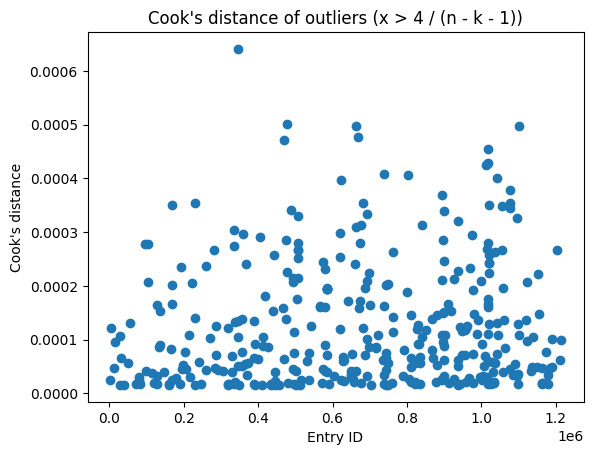

In [65]:
cook_threshold = 4 / (len(tested_predictors) -
                      len(tested_predictors.columns) - 1)
print(cook_threshold)
print(
    f'Found outliers: {len(extreme)} / {len(tested_predictors)} ({100 * len(extreme)/len(tested_predictors):.03f}%)')

plt.title("Cook's distance of outliers (x > 4 / (n - k - 1))")
plt.scatter(extreme.index, extreme['cooks_d'])
plt.xlabel("Entry ID")
plt.ylabel("Cook's distance")

output_path = f'{figure_base_path}/cooks_outliers.png'
safe_save_fig(output_path)


Removes outliers

In [66]:
tested_predictors = tested_predictors.drop(extreme.index)
tested_dependents = dependent.drop(extreme.index)

print(f'{len(tested_predictors)=}')

len(tested_predictors)=428071


# Model Creation

Creates a simple mixed effect logistic regression model.

In [67]:
from statsmodels.regression.mixed_linear_model import MixedLM

# Selects relevant project names.
pn_key = "Project Name"
tested_projects = df[pn_key].copy()
tested_projects = tested_projects[tested_predictors.index]

# Creates model.
mixed_model = MixedLM(
    tested_dependents,
    tested_predictors,
    tested_projects,
).fit()

mixed_model.summary()


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Mixed Linear Model Regression Results
========================================================================================
Model:                     MixedLM        Dependent Variable:        PullRequestIsMerged
No. Observations:          428071         Method:                    REML               
No. Groups:                20049          Scale:                     0.1839             
Min. group size:           1              Log-Likelihood:            -282658.7986       
Max. group size:           512            Converged:                 Yes                
Mean group size:           21.4                                                         
----------------------------------------------------------------------------------------
                                             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------
ControlPullRequestHasComments                -0.059    0.002 -32.076 0.000 -0.063 -0.055
ControlHasHashTagInDescription                0.045    0.002  28.688 0.000  0.042  0.048
ControlPullRequestHasCommentByExternalUser   -0.025    0.002 -13.740 0.000 -0.029 -0.022
ln(1 + ControlPullRequestLifeTimeInMinutes)  -0.219    0.003 -64.752 0.000 -0.226 -0.213
ln(1 + ControlNumberOfCommitsInPullRequest)  -0.166    0.012 -14.318 0.000 -0.188 -0.143
ln(1 + WeightedFirstOrderInDegreeCentrality)  0.351    0.010  35.821 0.000  0.331  0.370
ln(1 + IntegratorToSubmitterLinkIntensity)    0.612    0.016  38.528 0.000  0.581  0.643
Group Var                                     0.776    0.022                            
========================================================================================

"""

###

In [68]:
import os

# outputs results to a csv.

summ = mixed_model.summary()

fields = summ.tables[1]
output = pd.DataFrame()
for field in fields.columns:
    output[f'Dependency Model: {field}'] = fields[field]

print(output)
dir_name = f'{base_path}/coefs/{file_name}/'
output_path = f'{dir_name}/coefs.csv'
if not os.path.exists(dir_name):
    os.makedirs(dir_name)
output.to_csv(output_path)


                                             Dependency Model: Coef.   
ControlPullRequestHasComments                                 -0.059  \
ControlHasHashTagInDescription                                 0.045   
ControlPullRequestHasCommentByExternalUser                    -0.025   
ln(1 + ControlPullRequestLifeTimeInMinutes)                   -0.219   
ln(1 + ControlNumberOfCommitsInPullRequest)                   -0.166   
ln(1 + WeightedFirstOrderInDegreeCentrality)                   0.351   
ln(1 + IntegratorToSubmitterLinkIntensity)                     0.612   
Group Var                                                      0.776   

                                             Dependency Model: Std.Err.   
ControlPullRequestHasComments                                     0.002  \
ControlHasHashTagInDescription                                    0.002   
ControlPullRequestHasCommentByExternalUser                        0.002   
ln(1 + ControlPullRequestLifeTimeInMinutes)        